In [2]:
#imporitng the required libraries
import pathlib
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import average
from numpy import array

In [3]:
covid_images = glob.glob('.\\curated dataset\\covid\\*')

In [4]:
len(covid_images)

597

In [5]:
normal_images = glob.glob('.\\curated dataset\\normal\\*')

In [6]:
len(normal_images)

616

In [7]:
pneumonia_images = glob.glob('.\\curated dataset\\pneumonia\\*')

In [8]:
len(pneumonia_images)

616

In [9]:
normal = []
for i in normal_images:
    path = i
    normal.append(path)

In [10]:
pneumonia = []
for i in pneumonia_images:
    path = i
    pneumonia.append(path)

In [11]:
covid = []
for i in covid_images:
    path = i
    covid.append(path)

In [12]:
all_images=[]

In [13]:
all_images.extend(normal)
all_images.extend(pneumonia)
all_images.extend(covid)

In [14]:
len(all_images)

1829

In [15]:
all_images[0].split('\\')

['.', 'curated dataset', 'normal', 'IM-0115-0001.jpeg']

In [16]:
# Define  labels[], and data[]
labels = []  
data = []
from tqdm import tqdm

for i in tqdm(range(len(all_images))):
    image= cv2.imread(all_images[i])  #reading the image
    image=cv2.resize(image, (224,224)) #resizing
    image=np.array(image)  #converting into numpy array
    image = image/255  #scaling image
    data.append(image)
    cls = all_images[i].split('\\')[-2] #splitting  path
    if cls == 'pneumonia':
        lbl = 0
    elif cls=='normal' :
        lbl=1
    else:
        lbl=2
    labels.append(lbl)

100%|██████████████████████████████████████████████████████████████████████████████| 1829/1829 [00:32<00:00, 55.51it/s]


In [17]:
labels=np.array(labels)
data=np.array(data)
print(labels.shape)
print(data.shape)

(1829,)
(1829, 224, 224, 3)


In [18]:
from sklearn.model_selection import train_test_split,KFold

In [19]:
x_train , x_test ,y_train ,y_test = train_test_split(data,labels,test_size=0.2)

In [20]:
x_train , x_val ,y_train ,y_val = train_test_split(data,labels,test_size=0.2)

In [21]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(1463, 224, 224, 3) (1463,)
(366, 224, 224, 3) (366,)
(366, 224, 224, 3) (366,)


In [22]:
#applying data augumentation using ImageGenerator library provided in keras.preprocessing on training data
data_generator_train = tf.keras.preprocessing.image.ImageDataGenerator( rotation_range=15, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,horizontal_flip=True,fill_mode='nearest')

In [23]:
y_train = tf.keras.utils.to_categorical(y_train,3)
y_test = tf.keras.utils.to_categorical(y_test,3)
y_val=tf.keras.utils.to_categorical(y_val,3)

In [24]:
data_generator_train.fit(x_train)

In [25]:
resnet50v2 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classifier_activation="softmax",
)

In [26]:
model1 = Sequential()
model1.add(resnet50v2)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(3, activation='softmax'))

In [27]:
#summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 24,090,115
Trainable params: 24,044,675
Non-trainable params: 45,440
_________________________________________________________________


In [28]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [29]:
history1 = model1.fit(data_generator_train.flow(x_train,y_train , batch_size=8),validation_data=(x_val,y_val),epochs=50)

Epoch 1/50
183/183 [==============================] - 38s 169ms/step - loss: 0.6104 - accuracy: 0.7847 - val_loss: 18.7367 - val_accuracy: 0.5956
Epoch 2/50
183/183 [==============================] - 26s 144ms/step - loss: 0.3731 - accuracy: 0.8619 - val_loss: 3.0683 - val_accuracy: 0.5710
Epoch 3/50
183/183 [==============================] - 26s 144ms/step - loss: 0.3376 - accuracy: 0.8811 - val_loss: 10.2759 - val_accuracy: 0.3716
Epoch 4/50
183/183 [==============================] - 26s 144ms/step - loss: 0.2949 - accuracy: 0.8886 - val_loss: 2.2619 - val_accuracy: 0.4372
Epoch 5/50
183/183 [==============================] - 26s 145ms/step - loss: 0.2741 - accuracy: 0.9023 - val_loss: 0.4968 - val_accuracy: 0.8798
Epoch 6/50
183/183 [==============================] - 27s 145ms/step - loss: 0.2383 - accuracy: 0.9187 - val_loss: 0.4211 - val_accuracy: 0.8415
Epoch 7/50
183/183 [==============================] - 27s 145ms/step - loss: 0.2186 - accuracy: 0.9152 - val_loss: 0.6808 - val_

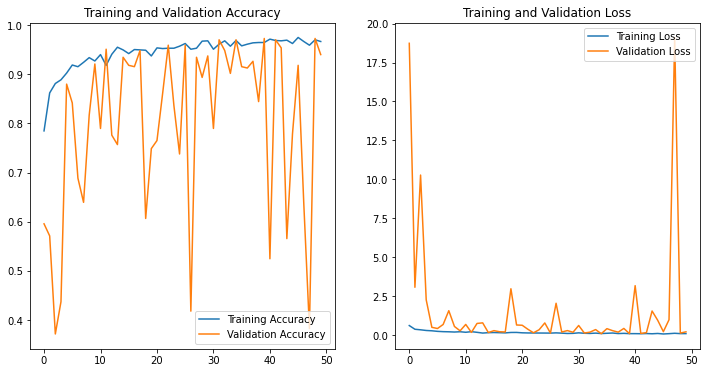

In [31]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']
epochs_range = range(50)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
model1.save('./base_model.h5')

D:\anaconda\envs\mygpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
score, accuracy = model1.evaluate(x_test,y_test)

12/12 [==============================] - 1s 115ms/step - loss: 0.1386 - accuracy: 0.9426


In [34]:
print("Testing Accuracy is : ", accuracy)

Testing Accuracy is :  0.9426229596138


In [35]:
y_pred = model1.predict(x_test)

In [36]:
y_test = np.argmax(y_test,axis=1)
y_pred = np.argmax(y_pred,axis=1)

In [39]:
from sklearn.metrics import classification_report,confusion_matrix

In [38]:
print(classification_report(y_test,y_pred,target_names=['Pneumonia', 'Normal', 'Covid']))

              precision    recall  f1-score   support

   Pneumonia       0.88      0.96      0.92       127
      Normal       0.98      0.87      0.92       120
       Covid       0.98      1.00      0.99       119

    accuracy                           0.94       366
   macro avg       0.95      0.94      0.94       366
weighted avg       0.95      0.94      0.94       366



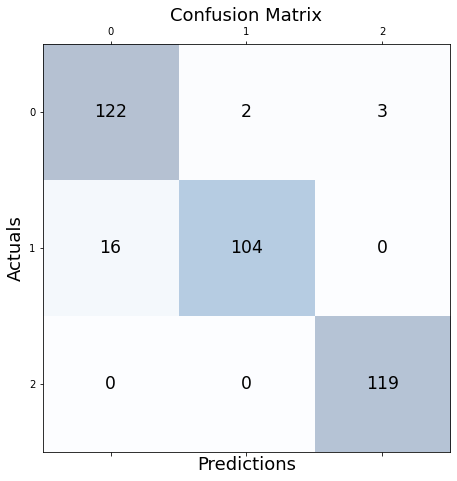

In [40]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()